# Polaris tutorial

In [1]:
import aplpy
from astropy.io import fits
%pylab inline
#%matplotlib widget
#plt.style.use(['dark_background'])

Populating the interactive namespace from numpy and matplotlib


## Read and prepare the map

In [2]:
figfile = '/user/workdir/albouyg/Gouldbelt/Polaris/HGBS_polaris_column_density_map.fits'

In [3]:
#Read map
HDU = fits.open(figfile)
im = HDU[0].data
header = HDU[0].header

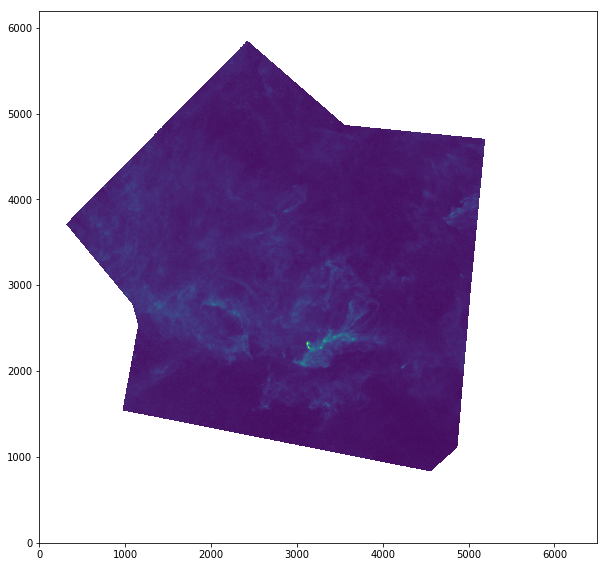

In [4]:
figure(figsize=(10,10))
imshow(im,origin='bottom')

In [5]:
header

SIMPLE  =                    T / Written by IDL:  Fri Jan  5 13:28:59 2018      
BITPIX  =                  -32 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 6500                                                  
NAXIS2  =                 6200                                                  
COMMENT Science data image                                                      
CREATOR = 'IDL               '                                                  
TELESCOP= 'Herschel Space Observatory'                                          
INSTRUME= 'SPIRE/PACS'                                                          
PROPOSAL= 'KPGT_pandre_1'                                                       
PRTITLE = 'Herschel Gould Belt Survey (HGBS)'                                   
COMMENT Reference publication of the survey: Andre' et al. (2010)               
COMMENT bibcode: 2010A&A...5

In [6]:
import reproject as proj

In [ ]:
hdproj = header.copy()

ratio = 0.00388889/0.00083333333333333

#Change pixel resolution
hdproj['CDELT1'] = -0.00388889
hdproj['CDELT2'] = 0.00388889
hdproj['CRPIX1'] = header['CRPIX1']/ratio
hdproj['CRPIX2'] = header['CRPIX2']/ratio
hdproj['NAXIS1'] = np.int(header['NAXIS1']/ratio)
hdproj['NAXIS2'] = np.int(header['NAXIS2']/ratio)
#Rotate the map
hdproj['CROTA1'] = 11.2116
hdproj['CROTA2'] = 11.2116


improj = proj.reproject_exact(HDU,hdproj)
improjnp = np.asarray(improj)
fits.writeto('/user/workdir/albouyg/Gouldbelt/Polaris/HGBS_polaris_column_density_map_rebin_rot.fits',improjnp[0,:,:], hdproj, overwrite=True)

In [ ]:
from pywavan import powspec, fan_trans, apodize, padding, subfits

INFO: Auto-setting vmin to  7.855e+19 [aplpy.core]
INFO: Auto-setting vmax to  1.718e+21 [aplpy.core]


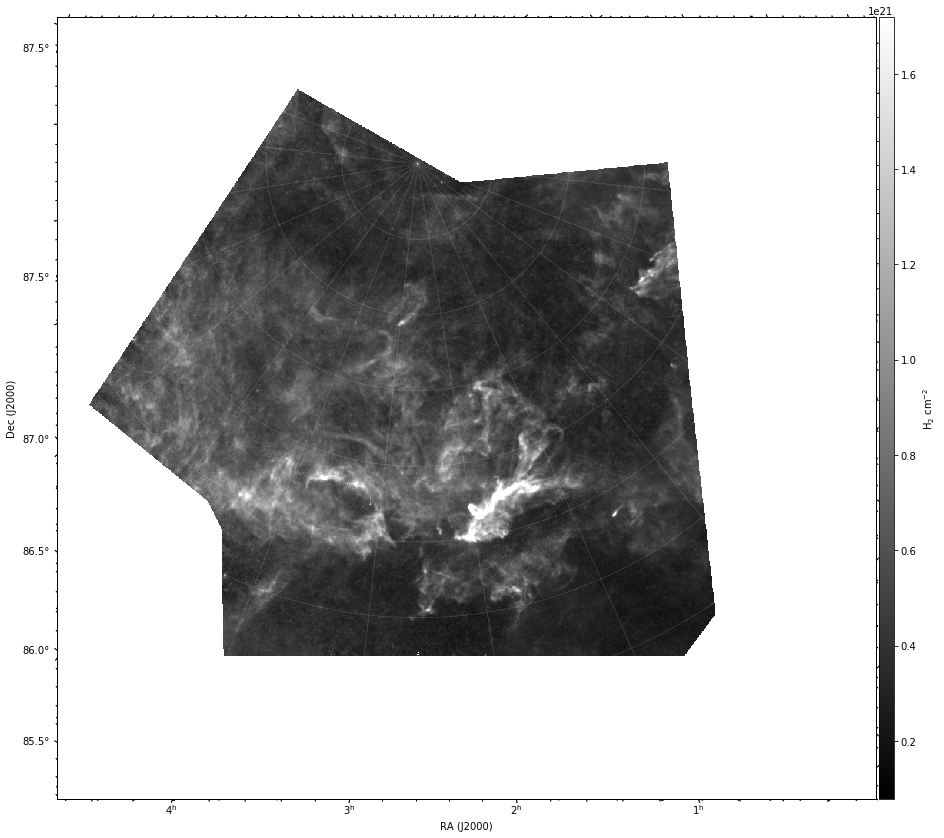

In [55]:
fig_all = plt.figure(1, figsize=(15,15))
fig = aplpy.FITSFigure('/user/workdir/albouyg/Gouldbelt/Polaris/HGBS_polaris_column_density_map_rebin_rot.fits',figure=fig_all)
fig.show_colorscale(cmap='gray')
fig.tick_labels.set_xformat('hh')
fig.tick_labels.set_yformat('dd.d')
fig.ticks.set_xspacing(15)  # degrees
fig.ticks.set_yspacing(0.5)  # degrees
fig.add_colorbar()
fig.add_grid()
fig.grid.set_alpha(0.15)
fig.colorbar.set_axis_label_text(r'H$_2$ cm$^{-2}$')

In [56]:
#Read map
HDU = fits.open('/user/workdir/albouyg/Gouldbelt/Polaris/HGBS_polaris_column_density_map_rebin_rot.fits')
im = HDU[0].data
header = HDU[0].header

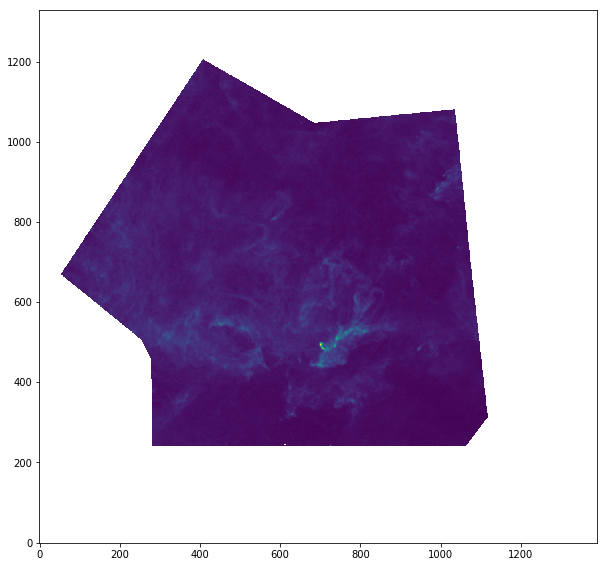

In [58]:
figure(figsize=(10,10))
imshow(im,origin='bottom')

In [59]:
#Cut the map
input = '/user/workdir/albouyg/Gouldbelt/Polaris/HGBS_polaris_column_density_map_rebin_rot.fits'
output = '/user/workdir/albouyg/Gouldbelt/Polaris/HGBS_polaris_column_density_map_rebin_rot_cut.fits'
coords = np.array([284,250,1041,1015])
subfits(input,output,coords)

Dimensions 758 766


In [60]:
#Read map
HDU = fits.open('/user/workdir/albouyg/Gouldbelt/Polaris/HGBS_polaris_column_density_map_rebin_rot_cut.fits')
im = HDU[0].data
header = HDU[0].header

INFO: Auto-setting vmin to  3.521e+19 [aplpy.core]
INFO: Auto-setting vmax to  2.201e+21 [aplpy.core]


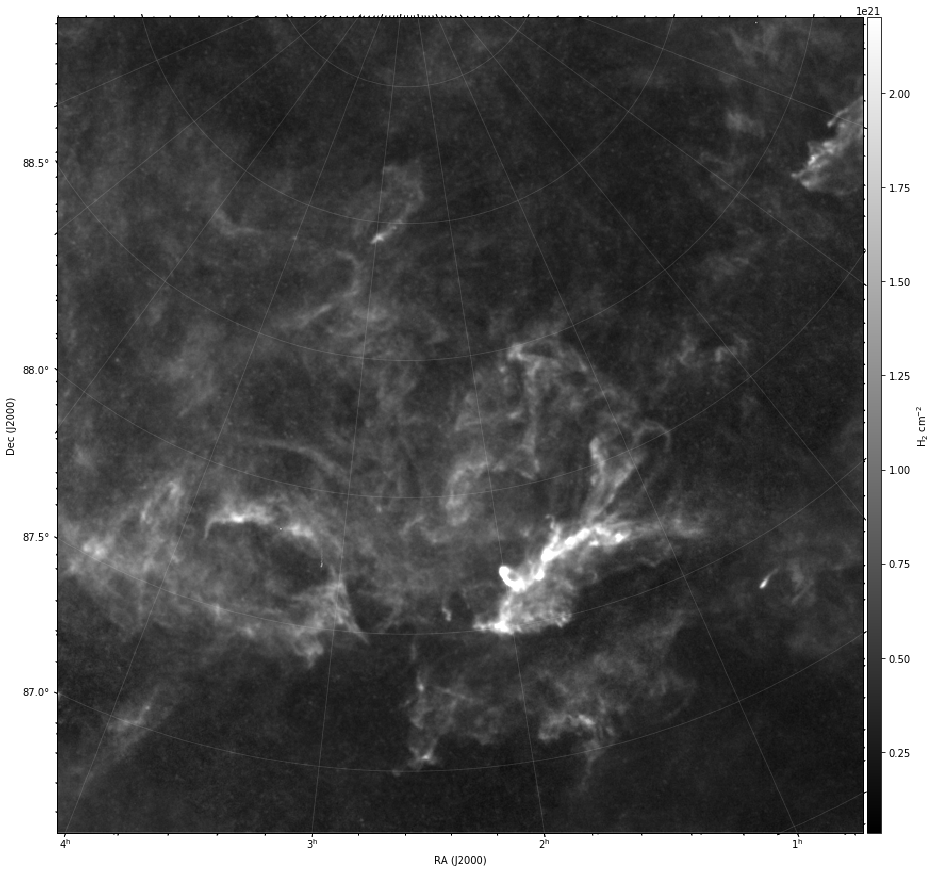

In [61]:
fig_all = plt.figure(1, figsize=(15,15))
fig = aplpy.FITSFigure('/user/workdir/albouyg/Gouldbelt/Polaris/HGBS_polaris_column_density_map_rebin_rot_cut.fits',figure=fig_all)
fig.show_colorscale(cmap='gray')
fig.tick_labels.set_xformat('hh')
fig.tick_labels.set_yformat('dd.d')
fig.ticks.set_xspacing(15)  # degrees
fig.ticks.set_yspacing(0.5)  # degrees
fig.add_colorbar()
fig.add_grid()
fig.grid.set_alpha(0.15)
fig.colorbar.set_axis_label_text(r'H$_2$ cm$^{-2}$')

In [ ]:
#Resolution in arcmin
reso = HDU[0].header['CDELT2'] * 60.

meanim = np.mean(im)
na = im.shape[1]
nb = im.shape[0]
imzm = im - meanim

#Apodization
tapper = apodize(nb,na,0.98)
imt = imzm *tapper
newdim = np.array((850,850))
imr = padding(imt,newdim[0],newdim[1])

#Fourier power spectrum
tab_k, spec_k = powspec(imr, reso=reso)

#noise = S1a[0,20]

In [ ]:
#Set a list of q
q=[]
q=[2.5]*26

#Wavelet power spectrum
wt, S11a, wav_k, S1a, q = fan_trans(im, reso=reso, q=q, qdyn=True, skewl=0.4, arrdim = newdim, smooth=False, angular=False, apodize=.98)

In [ ]:
plt.figure(figsize(12,9))
plt.plot(tab_k, spec_k, color='black',label=r'Total Fourier')
plt.plot(wav_k, (S1a[0,:]),'^', markersize = 11, markerfacecolor='none', markeredgecolor='black', label='Total wavelet')
plt.plot(wav_k, (S1a[2,:]),'D', markersize = 11, markerfacecolor='none', markeredgecolor='red', label='Gaussian wavelet')
plt.plot(wav_k, (S1a[1,:]),'^', markersize = 11, markerfacecolor='none', markeredgecolor='blue', label='Coherent wavelet')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$k$ (arcmin$^{-1}$)')
plt.ylabel(r'$P(k)$')
plt.legend()

In [ ]:
#Image reconstruction from the segmented wavelet coefficients
M=np.size(wav_k)
filaments = np.sum(wt[M:2*M,:,:].real,axis=0)
scale_free = np.sum(wt[2*M:3*M,:,:].real,axis=0)

#Plot images
figure(figsize=(20,10))
plt.subplot(1,2,1)
imshow(filaments,origin='bottom')
plt.title('Filaments')

plt.subplot(1,2,2)
imshow(scale_free,origin='bottom')
plt.title('Scale-free fractal simulation')